In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
import natasha
import matplotlib.pyplot as plt
import pickle
import keras

from gensim.models import word2vec
from tqdm import tqdm
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
def save(variable, file_name):
    with open(file_name, 'wb') as fout:
        pickle.dump(variable, fout)

def get(file_name):
    with open(file_name, 'rb') as fin:
        return pickle.load(fin)

In [142]:
df_train = pd.read_csv('train.csv')
df_train.columns = list(map(lambda x: x.strip(), df_train.columns))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159806 entries, 0 to 159805
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         159806 non-null  int64 
 1   tdate      159806 non-null  int64 
 2   tmane      159806 non-null  object
 3   ttext      159806 non-null  object
 4   trtw       159806 non-null  int64 
 5   tfav       159806 non-null  int64 
 6   tstcount2  159806 non-null  int64 
 7   tfol       159806 non-null  int64 
 8   tfrien     159806 non-null  int64 
 9   listcount  159806 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 12.2+ MB


In [143]:
df_test = pd.read_csv('test-mod1.csv')
df_test.columns = list(map(lambda x: x.strip(), df_test.columns))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67026 entries, 0 to 67025
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         67026 non-null  int64 
 1   tdate      67026 non-null  int64 
 2   tmane      67026 non-null  object
 3   ttext      67026 non-null  object
 4   tstcount2  67026 non-null  int64 
 5   tfol       67026 non-null  int64 
 6   tfrien     67026 non-null  int64 
 7   listcount  67026 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 4.1+ MB


# EDA

- id - уникальный номер сообщения в системе twitter
- tdate - дата публикации сообщения (твита)
- tmane - имя пользователя, опубликовавшего сообщение
- ttext - текст сообщения (твита)
- trtw - число повторных публикаций этого твита TARGET
- tfav - число сколько раз данное сообщение было добавлено в избранное другими пользователями TARGET
- tstcount - число всех сообщений пользователя в сети twitter
- tfol - количество фоловеров пользователя (кто читает пользователя)
- tfrien - количество друзей пользователя (кого читает пользователь)
- listcount - количество листов-подписок в которые добавлен твиттер-пользовател

## Обработка выбросов

Изобразим численные признаки с помощью ```scatter plot```

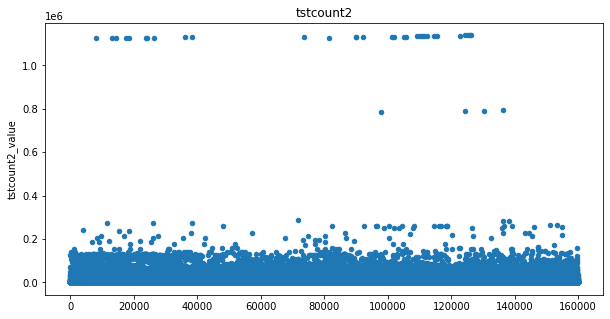

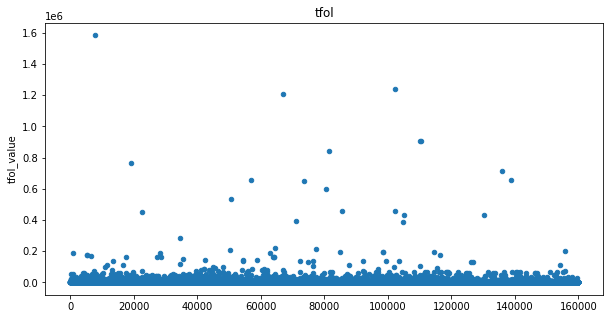

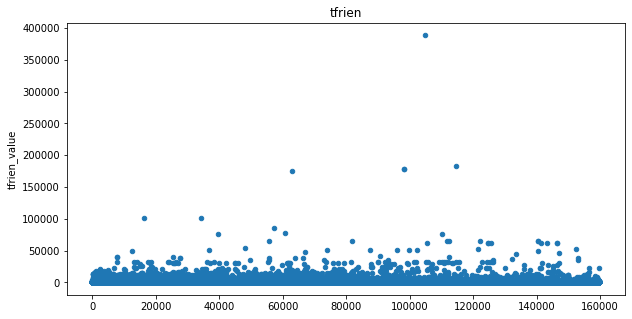

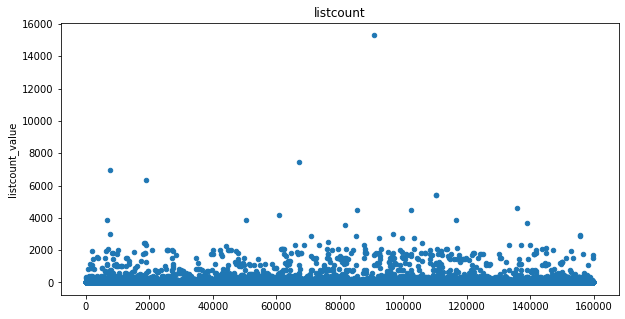

In [24]:
numerical_columns = ['tstcount2', 'tfol', 'tfrien', 'listcount']
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    plt.title(column)
    plt.scatter(np.arange(df_train.shape[0]), df_train[column], s=20)
    plt.ylabel(column + '_value')
    plt.show()

### Удаление выбросов с помощью интерквартильного размаха

In [42]:
def drop_numerical_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    Q25, Q75 = df[column].quantile([.25, .75])
    IQR = Q75 - Q25
    return df[
        (df[column] >= Q25 - 5 * IQR) &
        (df[column] <= Q75 + 5 * IQR)
    ]
print(f'Было строк: {df_train.shape[0]}')
for column in numerical_columns:
    df_train = drop_numerical_outliers(df_train, column)
print(f'Стало строк: {df_train.shape[0]}')

Было строк: 159806
Стало строк: 132244


#### Метод удаляет чересчур много строк

Заметно, что даже десятикратный IQR все равно удаляет слишком много значений, воспринимая их как выбросы.

Поэтому, воспользуемся визуальным анализом диаграмм рассеивания для удаления выбросов

In [45]:
df_train = pd.read_csv('train.csv')
df_train.columns = list(map(lambda x: x.strip(), df_train.columns))
print(f'Было строк: {df_train.shape}')
outliers_scopes = {
    'tstcount2': 0.6 * 1e6,
    'tfol': 0.4 * 1e6,
    'tfrien': 55000,
    'listcount': 2000
}
for column in outliers_scopes:
    df_train = df_train[df_train[column] <= outliers_scopes[column]]
print(f'Стало строк: {df_train.shape}')

Было строк: (159806, 10)
Стало строк: (159672, 10)


Теперь строк осталось гораздо больше

# Предобработка текстов твитов

## Добавление новых признаков

In [147]:
def url_exists(text):
    if 'http' in text:
        return 1
    return 0

def count_exclaimings(text):
    return text.count('!') + text.count('?')

def count_smiles(text):
    return text.count(':') - text.count('RT @')

def get_words_only(words: list) -> list:
    res = []
    for word in words:
        new_word = ''
        for letter in word:
            if letter.isalpha():
                new_word += letter
        res.append(new_word)
    return res
        
def vectorize_text(text, morph_vocab, embeddings):
    text = text.lower().strip().replace('\n', ' ').split(' ')
    text = get_words_only(text)
    vectorized_text = []
    for i, word in enumerate(text):
        new_word = morph_vocab(word)[0].normal
        try:
            vectorized_word = embeddings[new_word]
            vectorized_text.append(vectorized_word)
        except KeyError:
            vectorized_text.append(np.zeros(300))
    return np.array(vectorized_text).mean(axis=0).tolist()

def text_preprocessing(df):
    df['ttext_contains_url'] = df['ttext'].apply(lambda x: 1 if 'http' in x else 0)
    df['ttext_is_retweet'] = df['ttext'].apply(lambda x: 1 if '@' in x else 0)
    df['ttext_exclaimings'] = df['ttext'].apply(count_exclaimings)
    df['count_messages_tname'] = df['tmane'].map(df['tmane'].value_counts())
    vectorized_text = df['ttext'].progress_apply(vectorize_text, args=(morph_vocab, emb)).values.tolist()
    df.drop(columns=['ttext', 'tmane'], inplace=True)
    vectorized_df = pd.DataFrame(vectorized_text)
    df = pd.concat([df, vectorized_df], axis=1)

    return df

tqdm.pandas()
df_train = text_preprocessing(df_train)
df_test = text_preprocessing(df_test)




100%|██████████| 67026/67026 [01:04<00:00, 1033.49it/s]


In [148]:
save(df_train, 'df_train_vectorized.pkl')
save(df_test, 'df_test_vectorized.pkl')

In [4]:
df_train = get('df_train_vectorized.pkl')
df_test = get('df_test_vectorized.pkl')

df_train['trtw_tern'] = df_train['trtw'].apply(convert_trtw)
df_train['tfav_bin'] = df_train['tfav'].apply(lambda x: 1 if x > 0 else 0)

## Предобработка для модели LSTM

In [70]:
#- trtw - число повторных публикаций этого твита TARGET
#- tfav - число сколько раз данное сообщение было добавлено в избранное другими пользователями TARGET
def convert_trtw(x):
    if x == 0:
        return 0
    elif x == 1:
        return 1
    else:
        return 2
    
def reshape_into_tensor(x):
    return np.reshape(x.values, x.shape + (1, ))

def split_sample(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
    X_train = reshape_into_tensor(X_train)
    X_test = reshape_into_tensor(X_test)
    y_train = reshape_into_tensor(y_train)
    y_test = reshape_into_tensor(y_test)
    return (X_train, X_test, y_train, y_test)

n_layers = 128 
n_epoch = 5
n_batch_size = 16

## Обучаем модель 1, прогнозирующую ```trtw```

In [72]:
y = df_train['trtw_tern']
X = df_train.drop(columns=['trtw', 'tfav', 'id', 'tdate', 'trtw_tern', 'tfav_bin'])
X_train, X_test, y_train, y_test = split_sample(X, y)

In [73]:

lstm_model1 = keras.Sequential()
lstm_model1.add(keras.layers.LSTM(n_layers)) 

lstm_model1.add(keras.layers.Dense(5, activation = 'sigmoid'))

#оптимайзер Адам
opt = keras.optimizers.Adam()


lstm_model1.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=opt,
    metrics=[tf.keras.metrics.RootMeanSquaredError()])


batch_size = n_batch_size
epochs = n_epoch

# обучение
lstm_model1.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = batch_size, epochs = epochs)
lstm_model1.save('model1.h5')

Epoch 1/5
7991/7991 [==============================] - 1297s 162ms/step - loss: 0.3049 - root_mean_squared_error: 0.5521 - val_loss: 0.2587 - val_root_mean_squared_error: 0.5086
Epoch 2/5
7991/7991 [==============================] - 1390s 174ms/step - loss: 0.2480 - root_mean_squared_error: 0.4980 - val_loss: 0.2104 - val_root_mean_squared_error: 0.4587
Epoch 3/5
7991/7991 [==============================] - 1371s 172ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465 - val_loss: 0.1815 - val_root_mean_squared_error: 0.4260
Epoch 4/5
7991/7991 [==============================] - 1525s 191ms/step - loss: 0.1680 - root_mean_squared_error: 0.4099 - val_loss: 0.1526 - val_root_mean_squared_error: 0.3906
Epoch 5/5
7991/7991 [==============================] - 1579s 198ms/step - loss: 0.1475 - root_mean_squared_error: 0.3841 - val_loss: 0.1374 - val_root_mean_squared_error: 0.3706


### Confusion matrix

<AxesSubplot:title={'center':'confusion matrix'}>

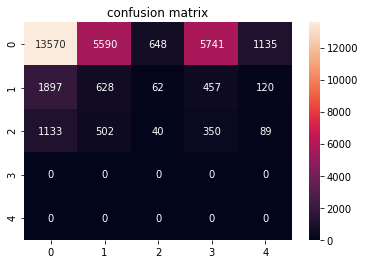

In [74]:
y_true = y_test.reshape(-1)
y_pred_0 = lstm_model1.predict(X_test).argmax(axis=1)
plt.title('confusion matrix')
heatmap(confusion_matrix(y_true, y_pred_0), annot=True, fmt='.0f')

## Предсказываем переменную ```trtw```

In [75]:
X_test_test = df_test.drop(columns=['id', 'tdate'])
X_test_test = np.reshape(X_test_test.values, X_test_test.shape + (1, ))
y_pred = lstm_model.predict(X_test_test).argmax(axis=1)

In [76]:
res_df = pd.DataFrame(df_test.loc[:, 'id'])
res_df['trtw'] = res_df.index.map(pd.Series(y_pred))
res_df

,id,trtw
0,410751187798217,4
1,410751187798218,4
2,410751187798219,2
3,410751187798220,4
4,410751187798221,4
...,...,...
67021,410751187865238,4
67022,410751187865239,4
67023,410751187865240,4
67024,410751187865241,4


## Обучаем модель 2, прогнозирующую ```tfav```

In [77]:
y = df_train['tfav_bin']
X = df_train.drop(columns=['trtw', 'tfav', 'id', 'tdate', 'trtw_tern', 'tfav_bin'])
X_train, X_test, y_train, y_test = split_sample(X, y)

In [78]:
lstm_model2 = keras.Sequential()
lstm_model2.add(keras.layers.LSTM(n_layers)) 

lstm_model2.add(keras.layers.Dense(5, activation = 'sigmoid'))

#оптимайзер Адам
opt = keras.optimizers.Adam()


lstm_model2.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=opt,
    metrics=[tf.keras.metrics.RootMeanSquaredError()])


batch_size = n_batch_size
epochs = n_epoch

# обучение
lstm_model2.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = batch_size, epochs = epochs)
lstm_model1.save('model2.h5')

Epoch 1/5
7991/7991 [==============================] - 1815s 227ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 9.6915e-04 - val_root_mean_squared_error: 0.0311
Epoch 2/5
7991/7991 [==============================] - 1830s 229ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 9.6897e-04 - val_root_mean_squared_error: 0.0311
Epoch 3/5
7991/7991 [==============================] - 1882s 235ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 9.6899e-04 - val_root_mean_squared_error: 0.0311
Epoch 4/5
7991/7991 [==============================] - 2161s 270ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 9.6907e-04 - val_root_mean_squared_error: 0.0311
Epoch 5/5
7991/7991 [==============================] - 1766s 221ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 9.6903e-04 - val_root_mean_squared_error: 0.0311


In [79]:
X_test_test = df_test.drop(columns=['id', 'tdate'])
X_test_test = np.reshape(X_test_test.values, X_test_test.shape + (1, ))
y_pred = lstm_model.predict(X_test_test)

In [83]:
y_pred

array([[0.3600924 , 0.32408553, 0.3146832 , 0.30261666, 0.39068595],
       [0.17512646, 0.14906374, 0.1585432 , 0.1434238 , 0.17964128],
       [0.06978476, 0.06974548, 0.07441667, 0.06583172, 0.06608918],
       ...,
       [0.36638463, 0.32497615, 0.35825288, 0.25353265, 0.4625542 ],
       [0.2788112 , 0.24061263, 0.26910946, 0.19332984, 0.34593767],
       [0.18298295, 0.1494528 , 0.1799573 , 0.12340938, 0.22278592]],
      dtype=float32)

In [80]:
res_df['tfav'] = res_df.index.map(pd.Series(y_pred.argmax(axis=1)))
res_df

,id,trtw,tfav
0,410751187798217,4,4
1,410751187798218,4,4
2,410751187798219,2,2
3,410751187798220,4,4
4,410751187798221,4,4
...,...,...,...
67021,410751187865238,4,4
67022,410751187865239,4,4
67023,410751187865240,4,4
67024,410751187865241,4,4


### Confusion matrix

<AxesSubplot:title={'center':'confusion matrix'}>

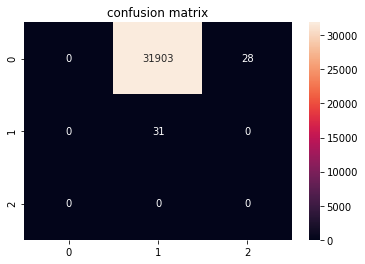

In [81]:
y_true = y_test.reshape(-1)
y_pred_0 = lstm_model2.predict(X_test).argmax(axis=1)
plt.title('confusion matrix')
heatmap(confusion_matrix(y_true, y_pred_0), annot=True, fmt='.0f')

In [82]:
res_df['tfav'].value_counts()

4    51145
0     9667
2     6207
3        4
1        3
Name: tfav, dtype: int64

In [85]:
res_df.to_csv('subm.csv', index=False)